In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
import os
import seaborn as sns

from glob import glob
from datetime import datetime
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit

import sys
sys.path.insert(0, "..")

from utils import fileio
from utils import visualise
from utils import geometry
from utils import matrices
from source import segmentation_hand
from source import graham_scan

In [3]:
inst_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Instant_data/'
inc_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Incremental_data/'
uns_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Unstretched_data/'
cont_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Continuous_data/'
save_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\comparison_plots/'
save_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/'

In [5]:
dat_20151007_1_GSV=pd.read_csv(inst_dir+'20151007_1_GSV_GFPtub-CheHis_uf_8p6_MP_pooled_mech.csv')
dat_20231121_1_IN=pd.read_csv(inst_dir+'20231121_1_IN_GFPCAAX-CheHis_uf_8p6_SP_pooled_mech.csv')
dat_20231128_1_IP=pd.read_csv(inst_dir+'20231128_1_IP_GFPCAAX-CheHis_uf_8p6_SP_pooled_mech.csv')
dat_20240510_1_IN=pd.read_csv(inst_dir+'20240510_1_IN_GFPCAAX-CheHis_uf_8p6_SP_pooled_mech.csv')
dat_20240503_1_IP=pd.read_csv(inst_dir+'20240503_1_IP_GFPCAAX-CheHis_uf_8p6_SP_pooled_mech.csv')



inc_20231005_1_IP=pd.read_csv(inc_dir+'20231005_1_IP_GFPCAAX-CheHis_us_8p6_SP_pooled_mech.csv')
inc_20240117_1_IP=pd.read_csv(inc_dir+'20240117_1_IP_GFPCAAX-CheHis_us_8p6_SP_pooled_mech.csv')
inc_20240320_2_IN=pd.read_csv(inc_dir+'20240320_2_IN_GFPCAAX-CheHis_us_8p6_SP_pooled_mech.csv')



uns_20151125_1_GSV=pd.read_csv(uns_dir+'20151125_1_GSV_GFPtub-CheHis_uu_0p5_MP_pooled_mech.csv')
uns_20240117_2_IP=pd.read_csv(uns_dir+'20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP_pooled_mech.csv')
uns_20231012_2_IP=pd.read_csv(uns_dir+'20231012_2_IP_GFPCAAX-CheHis_uu_0p5_SP_pooled_mech.csv')
uns_20231019_1_IP=pd.read_csv(uns_dir+'20231019_1_IP_GFPCAAX-CheHis_uu_0p5_SP_pooled_mech.csv')

con_20240412_2_IP=pd.read_csv(cont_dir+'20240412_2_IP_GFPCAAX-CheHis_uc_8p6_SP_pooled_mech.csv')
con_20240503_2_IP=pd.read_csv(cont_dir+'20240503_2_IP_GFPCAAX-CheHis_uc_8p6_SP_pooled_mech.csv')




In [6]:
micron_size=553.57
pixel_size=1024

In [9]:
mat_dir=sorted(glob(inst_dir+'20240503_1_IP_GFPCAAX-CheHis_uf_*/*/*/Matrices/'))
mat_dir


['C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Instant_data\\20240503_1_IP_GFPCAAX-CheHis_uf_8p6\\20240503_1_IP_GFPCAAX-CheHis_uf_0p5_SP_fr001\\2024-05-28_09-37-02\\Matrices\\',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Instant_data\\20240503_1_IP_GFPCAAX-CheHis_uf_8p6\\20240503_1_IP_GFPCAAX-CheHis_uf_8p6_SP_fr001\\2024-05-28_09-37-39\\Matrices\\',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Instant_data\\20240503_1_IP_GFPCAAX-CheHis_uf_8p6\\20240503_1_IP_GFPCAAX-CheHis_uf_8p6_SP_fr006\\2024-05-28_09-38-16\\Matrices\\',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Instant_data\\20240503_1_IP_GFPCAAX-CheHis_uf_8p6\\20240503_1_IP_GFPCAAX-CheHis_uf_8p6_SP_fr011\\2024-05-28_09-38-51\\Matrices\\',
 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output\\Instant_data\\20240503_1_IP_GFPCAAX-CheHis_uf_8p6\\20240503_1_IP_GFPCAAX-CheHis_uf_8p6_SP_fr016\\2024-05-28_09-39-31\\Matrices

In [10]:
i=0

A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
R=R-np.mean(R, axis=0)
R=R*(micron_size/pixel_size)

N_c=np.shape(C)[0]
N_v=np.shape(C)[1]
N_e=np.shape(A)[0]

cec=geometry.get_edge_count(B)
cc=geometry.get_cell_centres(C, R, cec)
c=geometry.get_edge_centroids(A,R)
t=geometry.get_tangents(A,R)
l=geometry.get_edge_lengths(t)
L=geometry.get_perimeters(A,B,R)
nij=geometry.get_normals(B, t, N_c, N_e)
Ai=geometry.get_areas(A, B, R)


In [11]:
def get_perimeter_centroid(A, B, R):
    c=geometry.get_edge_centroids(A,R)
    t=geometry.get_tangents(A,R)
    l=geometry.get_edge_lengths(t)
    L=geometry.get_perimeters(A,B,R)
    cc_P=(abs(B)@(l[:,None]*c))/L[:, None]
    return cc_P

def get_area_centroid(A,B, R):
    N_c=np.shape(B)[0]
    N_e=np.shape(B)[1]

    c=geometry.get_edge_centroids(A,R)
    t=geometry.get_tangents(A,R)
    nij=geometry.get_normals(B, t, N_c, N_e)
    Ai=geometry.get_areas(A, B, R)

    cc_A=np.zeros((N_c, 2))
    for i in range(N_c):
        for j in range(N_e):
            if abs(B[i,j])==1:
                cc_A[i]+=(c[j]*np.dot(nij[i,j], c[j]))/(3*Ai[i])
    return cc_A


def get_shape_tensor_J(B, C,R, cc):
    N_c=np.shape(C)[0]
    N_v=np.shape(C)[1]
    S_J=np.zeros((N_c,2,2))

    cec=geometry.get_edge_count(B)
    cc=geometry.get_cell_centres(C, R, cec)


    for i in range(N_c):
        for k in range(N_v):
            if C[i,k]==1.0:
                S_J[i] += (1.0/cec[i])*np.outer((R[k]-cc[i]),(R[k]-cc[i]))
    
    return S_J

def get_shape_tensor_P(A, B,R):

    cc_P=get_perimeter_centroid(A, B, R)
    c=geometry.get_edge_centroids(A,R)
    t=geometry.get_tangents(A,R)
    l=geometry.get_edge_lengths(t)

    N_c=np.shape(B)[0]
    N_e=np.shape(B)[1]

    S_P=np.zeros((N_c,2,2))
    for i in range(N_c):
        for j in range(N_e):
            if abs(B[i,j])==1.0:
                S_P[i] += l[j]*(np.outer((c[j]-cc_P[i]),(c[j]-cc_P[i]))+ (1/12)*np.outer(t[j],t[j]))
    
    return S_P

def get_shape_tensor_A(A,B,R):

    N_c=np.shape(B)[0]
    N_e=np.shape(B)[1]
    N_v=np.shape(A)[1]

    cc_A=get_area_centroid(A, B, R)
    c=geometry.get_edge_centroids(A,R)
    t=geometry.get_tangents(A,R)
    nij=geometry.get_normals(B, t, N_c, N_e)

    
    A_tri=np.zeros((N_c,N_e))
    for i in range(N_c):
        for j in range(N_e):
            if B[i,j]!=0:
                for k in range(N_v):
                    if A[j,k]!=0:
                        A_tri[i,j]=np.dot(R[k]-cc_A[i], nij[i,j])/2
    
    S_A=np.zeros((N_c,2,2))
    for i in range(N_c):
        for j in range(N_e):
            if abs(B[i,j])==1.0:
                S_A[i] +=(A_tri[i,j]/2)*(np.outer((c[j]-cc_A[i]),(c[j]-cc_A[i]))+ (1/12)*np.outer(t[j],t[j]))
    return S_A

def get_circ_and_shape_axis(S):
    evals_S, evecs_S = np.linalg.eig(S)
    shape_vec=np.array([evecs_S[x][:,evals_S[x].argmax()] for x in range(len(evals_S))])
    evals_S= np.sort(evals_S, axis=1)
    circ=evals_S[:,0]/evals_S[:,1]

    shape_axis=np.arctan2(shape_vec[:,1]/np.linalg.norm(shape_vec, axis=1),shape_vec[:,0]/np.linalg.norm(shape_vec, axis=1))
    shape_axis[np.where(shape_axis<0)]=shape_axis[np.where(shape_axis<0)]+np.pi

    return circ, shape_axis

In [373]:
S_J=get_shape_tensor_J(B, C, R, cc)
S_P=get_shape_tensor_P(A, B, R)
S_A=get_shape_tensor_A(A, B, R)


In [444]:


circ_J, shape_axis_J=get_circ_and_shape_axis(S_J)
circ_P, shape_axis_P=get_circ_and_shape_axis(S_P)
circ_A, shape_axis_A=get_circ_and_shape_axis(S_A)


In [12]:

A=np.loadtxt(glob(mat_dir[0]+'/*Matrix_A*.txt')[0])
B=np.loadtxt(glob(mat_dir[0]+'/*Matrix_B*.txt')[0])
C=np.loadtxt(glob(mat_dir[0]+'/*Matrix_C*.txt')[0])
R=np.loadtxt(glob(mat_dir[0]+'/*Matrix_R*.txt')[0])
R=R-np.mean(R, axis=0)
R=R*(micron_size/pixel_size)

S_J=get_shape_tensor_J(B, C, R, cc)
S_P=get_shape_tensor_P(A, B, R)
S_A=get_shape_tensor_A(A, B, R)



circ_J, shape_axis_J=get_circ_and_shape_axis(S_J)
circ_P, shape_axis_P=get_circ_and_shape_axis(S_P)
circ_A, shape_axis_A=get_circ_and_shape_axis(S_A)


shape_dat=np.array([np.linspace(0, len(circ_J)-1, len(circ_J)),np.zeros(len(circ_J)),circ_J, circ_P, circ_A, shape_axis_J, shape_axis_P, shape_axis_A]).T

for i in range(1,len(mat_dir)):

    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])
    R=R-np.mean(R, axis=0)
    R=R*(micron_size/pixel_size)

    S_J=get_shape_tensor_J(B, C, R, cc)
    S_P=get_shape_tensor_P(A, B, R)
    S_A=get_shape_tensor_A(A, B, R)

    circ_J, shape_axis_J=get_circ_and_shape_axis(S_J)
    circ_P, shape_axis_P=get_circ_and_shape_axis(S_P)
    circ_A, shape_axis_A=get_circ_and_shape_axis(S_A)


    shape_dat=np.vstack((shape_dat,np.array([np.linspace(0, len(circ_J)-1, len(circ_J)),np.ones(len(circ_J))*i,circ_J, circ_P, circ_A, shape_axis_J, shape_axis_P, shape_axis_A]).T))

all_shape_dat=pd.DataFrame(shape_dat, columns=["cell_id_old","tm_frame", "circ_J", "circ_P", "circ_A", "shape_axis_J", "shape_axis_P", "shape_axis_A"])
all_shape_dat

,cell_id_old,tm_frame,circ_J,circ_P,circ_A,shape_axis_J,shape_axis_P,shape_axis_A
0,0.0,0.0,0.895648,0.906368,0.893515,0.058093,0.002158,0.058640
1,1.0,0.0,0.868305,0.894888,0.869944,0.213755,0.357640,0.251468
2,2.0,0.0,0.635733,0.684661,0.641298,2.082324,2.144851,2.076595
3,3.0,0.0,0.486371,0.596236,0.500101,0.105390,0.062916,0.094021
4,4.0,0.0,0.816836,0.868367,0.821209,2.151572,2.145247,2.158750
...,...,...,...,...,...,...,...,...
9904,377.0,27.0,0.603343,0.849272,0.778867,0.095748,0.283471,0.259815
9905,378.0,27.0,0.613449,0.703318,0.630747,0.578541,0.604165,0.597914
9906,379.0,27.0,0.408647,0.502392,0.427239,3.133365,0.000797,3.126871
9907,380.0,27.0,0.753895,0.826479,0.788039,0.186199,0.226778,0.217027


In [14]:
dat_20240503_1_IP

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,...,tm_frame,cell_perimeter_nd,cell_area_nd,cell_P_eff_nd,cell_shear,cell_zeta,major_stress_axis_alignment_rads,parent_id,divisions,angle_horizontal
0,0.0,63.473239,250.598985,4.009600,0.895648,4.0,0.058093,137.229007,-198.698190,62,...,0,1.394101,0.120889,-0.243201,0.027194,0.021382,1.628889,NaN,0,0.058093
1,1.0,73.721089,333.742322,4.035395,0.868305,4.0,0.213755,130.471560,-166.532745,294,...,0,1.619180,0.160997,-0.089747,0.038912,0.025967,1.784552,NaN,0,0.213755
2,2.0,69.791338,295.166151,4.062265,0.635733,4.0,2.082324,41.273269,-125.582621,248,...,0,1.532869,0.142388,-0.135502,0.109636,0.075914,0.511528,NaN,0,1.059268
3,3.0,65.855941,252.644691,4.143238,0.486371,4.0,0.105390,13.838037,83.222469,181,...,0,1.446433,0.121876,-0.170272,0.125511,0.088656,1.676186,NaN,0,0.105390
4,4.0,72.306699,323.221548,4.021873,0.816836,4.0,2.151572,-21.570981,121.064169,137,...,0,1.588115,0.155922,-0.112488,0.032830,0.022437,0.580775,NaN,0,0.990021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9904,377.0,75.273117,412.794246,3.704871,0.603343,8.0,0.095748,52.378969,69.714412,182,...,27,1.787537,0.232790,-0.083968,0.037266,0.027271,1.666545,NaN,0,0.095748
9905,378.0,84.203700,520.486055,3.690852,0.613449,8.0,0.578541,178.202619,95.325133,133,...,27,1.999614,0.293521,0.023937,0.117520,0.080447,0.578541,NaN,0,0.578541
9906,379.0,80.316174,417.908511,3.928822,0.408647,8.0,3.133365,118.264071,93.297899,150,...,27,1.907296,0.235674,0.039121,0.234875,0.146167,3.133365,NaN,0,0.008228
9907,380.0,89.701125,595.738811,3.675107,0.753895,8.0,0.186199,147.861685,126.814833,77,...,27,2.130164,0.335959,0.086959,0.071419,0.047549,0.186199,NaN,0,0.186199


In [15]:
dat_20240503_1_IP_circ=dat_20240503_1_IP.merge(all_shape_dat, on=['tm_frame', 'cell_id_old'])

In [16]:
dat_20240503_1_IP_circ.to_csv(save_folder+"/20240503_1_IP_GFPCAAX-CheHis_uf_8p6_SP_pooled_mech_circ.csv",index=False)

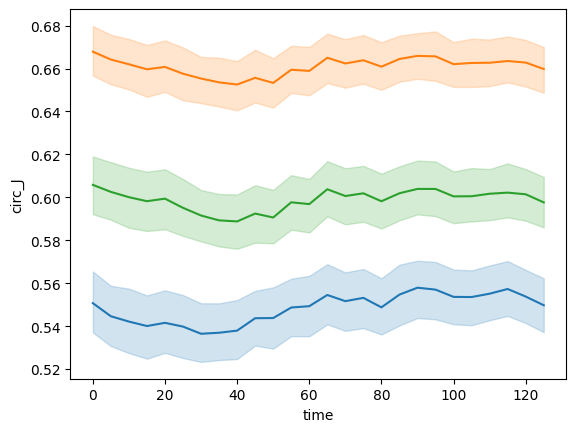

<AxesSubplot: xlabel='time', ylabel='circ_J'>

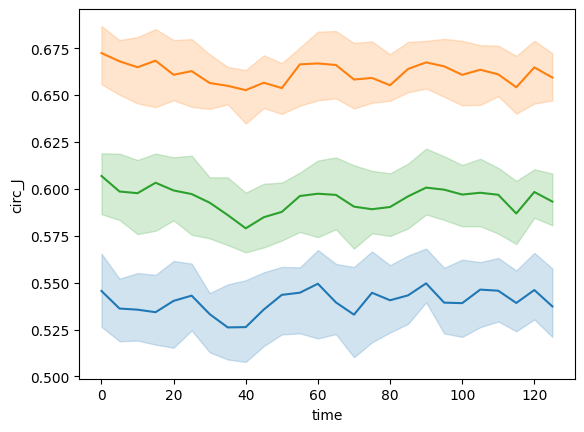

In [453]:
sns.lineplot(uns_20231019_1_IP_circ, x='time',y='circ_J' )
sns.lineplot(uns_20231019_1_IP_circ, x='time',y='circ_P' )
sns.lineplot(uns_20231019_1_IP_circ, x='time',y='circ_A' )
plt.show()

sns.lineplot(uns_20231019_1_IP_circ, x='time',y='circ_J' , estimator="median")
sns.lineplot(uns_20231019_1_IP_circ, x='time',y='circ_P' , estimator="median" )
sns.lineplot(uns_20231019_1_IP_circ, x='time',y='circ_A'  , estimator="median")

In [500]:
sns.scatterplot(uns_20231019_1_IP_circ, x='cell_zeta',y='shape_axis_J', hue='state' )
plt.show()
sns.scatterplot(uns_20231019_1_IP_circ, x='cell_zeta',y='shape_axis_P', hue='state'  )
plt.show()
sns.scatterplot(uns_20231019_1_IP_circ, x='cell_zeta',y='shape_axis_A' , hue='state' )
plt.show()



ValueError: Could not interpret value `state` for parameter `hue`